In [1]:
# Published at FocalPlane https://focalplane.biologists.com/?p=11702
# Andrey Andreev, Desiderio Ascencio
# California Institute of Technology, David Prober lab
# aandreev@caltech.edu
# 2022

# Required libraries:
# 'pandas',
# 'matplotlib',
# 'numpy',
# 'skimage'  # NB: install as 'scikit-image'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
from scipy.stats import pearsonr
import matplotlib as mpl
from matplotlib.ticker import FixedLocator
from matplotlib.colorbar import Colorbar
from skimage import io
import matplotlib.ticker as mticker
import os 
import random
import time
from matplotlib import gridspec

Helper function to be used for normalizing data

In [2]:
def normalizeData(data):
    if type(data).__module__ == np.__name__: # if we work with numpy data
        normVector = (data - data.min())/(data.max() - data.min())
        return normVector
    
    dataCopy = copy.deepcopy(data)
    for i in range(len(dataCopy)):
        min_data = np.min(dataCopy.iloc[i])
        max_data = np.max(dataCopy.iloc[i])
        tt = (np.array(dataCopy.iloc[i]) - min_data) / (max_data - min_data)
        dataCopy.iloc[i] = tt
    return dataCopy

This function creates the model of GCaMP response to LED onset

In [3]:
def modelOnset(tau=200, phase = 300, n=700):
    onset_model = np.zeros(n) # pre-allocatre memory with empty array of zeros
    decay = lambda t: np.exp(-t/tau) # exponential decay
    vfunc = np.vectorize(decay)
    onset_model[phase:] = vfunc(np.array(range(phase, n))) # in our experiment LED turns on at frame 300
    
    return onset_model

At this point we have saved the TIFF file, here we can display its first frame

Video shape:  (700, 136, 159)


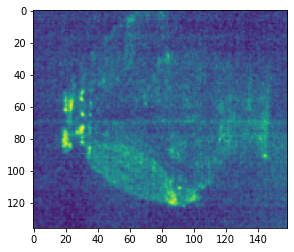

In [4]:
LED_video = io.imread('../data/downsampledpoint5_coloradjusted_edited_920_100mW_bin4x_200msExp_0umZ_10Slices_LED30zstackOFF-10ZstacksON_30ZstacksOFF_2-trial1-1.tif')
print("Video shape: ", LED_video.shape)

LED_video_frames = LED_video.shape[0]
LED_video_y_pixels = LED_video.shape[1]
LED_video_x_pixels = LED_video.shape[2]

video_first_frame = copy.deepcopy(LED_video[0])
plt.imshow(video_first_frame);

### Creating dataframe from pixel activity 

In [5]:
# Empty arrays to store information about video
coordinates_list_LED = []
activity_matrix_LED = np.zeros((LED_video_y_pixels * LED_video_x_pixels, LED_video_frames))
pixel_coordinates_LED = np.zeros((LED_video_y_pixels * LED_video_x_pixels, 2)) #two columns for x and y coords
pixel_counter_LED = 0

startTime = time.time()
# load data pixel-by-pixel into a numpy array
for i in range(LED_video_y_pixels): 
    for j in range(LED_video_x_pixels):
        activity = np.array(LED_video[:, i, j])
                        
        activity_matrix_LED[pixel_counter_LED] = normalizeData(activity) 
        pixel_coordinates_LED[pixel_counter_LED] = np.array([j,i])
        coordinates_list_LED.append((j,i))
        
        pixel_counter_LED += 1
        
print("Run time: {0} seconds".format(time.time() - startTime))

Run time: 0.3458082675933838 seconds


In [6]:
columns = range(1, activity_matrix_LED.shape[1]+1) # setting column values to be frame numbers
columns = ["{:02d}".format(x) for x in columns]

# convert numpy to panda data frame:
df = pd.DataFrame(data=activity_matrix_LED, columns=columns)
# last column represents coordinates:
df['coords'] = coordinates_list_LED

# show top 5 rows:
df.head()

,01,02,03,04,05,06,07,08,09,10,...,692,693,694,695,696,697,698,699,700,coords
0,0.408984,0.421968,0.540733,0.569459,0.479471,0.470246,0.556475,0.438061,0.604402,0.270016,...,0.529453,0.393944,0.447636,0.298441,0.510252,0.624956,0.453502,0.328872,0.606457,"(0, 0)"
1,0.847902,0.509877,0.148483,0.324790,0.710394,0.598063,0.763331,0.308522,0.655778,0.287734,...,0.525759,0.917560,0.489154,0.363589,0.445513,0.587928,0.403228,0.386507,0.592318,"(1, 0)"
2,0.832665,0.419121,0.456003,0.436952,0.620143,0.570599,0.651043,0.653482,0.350119,0.258524,...,0.492885,0.756926,0.560260,0.665737,0.569379,0.403671,0.640762,0.404426,0.645118,"(2, 0)"
3,0.484298,0.317253,0.496343,0.425337,0.457182,0.318136,0.520053,0.440850,0.191575,0.346134,...,0.129966,0.395195,0.259995,0.567411,0.184260,0.260436,0.558772,0.089545,0.219574,"(3, 0)"
4,0.603375,0.359790,0.527626,0.038376,0.291439,0.655467,0.415042,0.527086,0.536025,0.398243,...,0.234569,0.403945,0.045773,0.745396,0.223549,0.271943,0.632272,0.156199,0.583340,"(4, 0)"


`Fs` defines sampling rate of the data (in seconds)

`xaxis` variable is used to plot the time axis in seconds instead of frames

In [7]:
Fs = 0.2 # sampling rate, seconds
xaxis = np.asarray(range(0,700))*Fs

Define folder where we will save plots as PNG files

In [8]:
saveFolder = os.getcwd() # current (notebook's) folder

### Showing spatial + temporal information of pixels

In [9]:
font = {'family' : 'normal',
        'weight' : 'normal', #another option: bold
        'size'   : 15}

mpl.rc('font', **font)

Setting `example_rois` to hold information on 4 different example pixels. We plot both their spatial and temporal information 

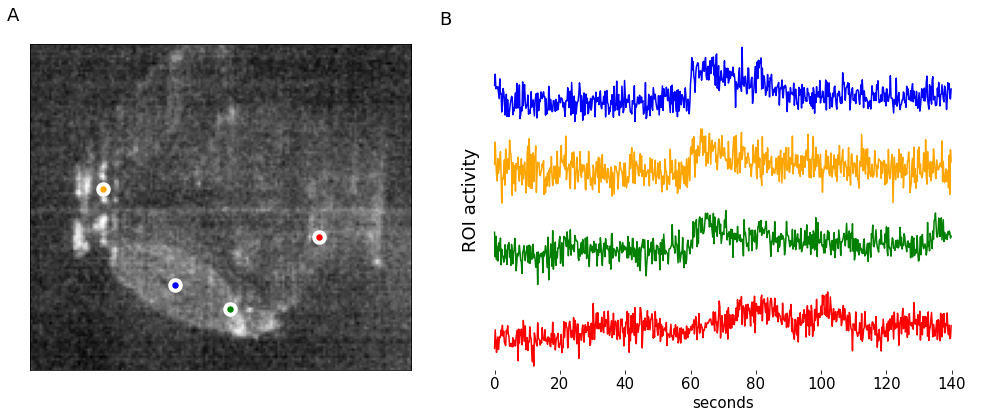

In [17]:
# pick sample pixels by coordinates, assign color to each
example_rois = {(60, 100):'blue', (30,60):'orange', (83, 110):'green', (120,80):'red'}

# define size and background color of the figure
fig = plt.figure(constrained_layout=False, figsize=(18,6))
fig.patch.set_facecolor('white')

# create grid layout with 4 rows and 2 columns
gs = fig.add_gridspec(4, 2, hspace=0, wspace= 0)

# first subplot will occupy 4 rows in the 1st column
ax1 = fig.add_subplot(gs[0:4, 0])
ax1.text(-10, -10, 'A', size=18)

# turn off axis and labels
ax1.axes.yaxis.set_visible(False)
ax1.axes.xaxis.set_visible(False)
ax1.imshow(video_first_frame, cmap='gray') #showing the first frame 

for roi in range(0, len(example_rois)):

    ax = fig.add_subplot(gs[roi, 1])

    key = list(example_rois.keys())[roi]
    pixel_activity = np.array(df.loc[df['coords'] == (key[0], key[1])])[0][:700] #collecting activity from the dataframe 
    ax.plot(xaxis, pixel_activity, color=example_rois[key])
    ax.axis('off')
    # add roi location to the image
    ax1.scatter(key[0],key[1],s=110, facecolor=example_rois[key], edgecolor='white', linewidths=4)
    if roi==0:
        ax.text(-17, 1.3, 'B', size=18)


ax.text(-10, 1.6, 'ROI activity', size=18,rotation='vertical')

# turn axes back on for the last line plot
ax.axis('on')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.set_xlabel('seconds')


# save figure as PNG file in the same folder as the notebook
plt.savefig(saveFolder + '/pixel_examples.png')

Generating the LED onset model that we will use to correlate pixels to 

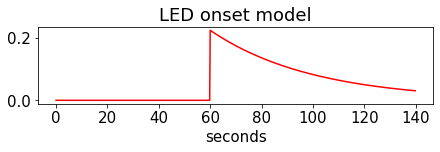

In [11]:
fig = plt.figure(constrained_layout=True, figsize=(6,2));
plt.plot(xaxis, modelOnset(), color='red', label='onset model')
plt.title('LED onset model');
plt.xlabel('seconds');

Creating matrix of the correlated pixels; subset data frame from original data frame 

In [12]:
correlation_onset = [] # saving coordinates and correlation coefficient of pixels
correlation_map = np.zeros((LED_video_y_pixels, LED_video_x_pixels)) # image that holds correlation values per pixel 

start_time = time.time() #keeping track of how long this code runs 

for i in range(len(df)):
    activity_correlation = np.array(df.iloc[i])[:700] # pixel activity
    activity_coordinates = df.iloc[i]['coords']       # pixel coordinates 
    
    p_onset = pearsonr(activity_correlation, modelOnset())[0] #grabbing r corr value
    
    # only save pixels that have correlation with model > 0.7
    if (p_onset**2) > .7:
        correlation_onset.append([activity_coordinates, p_onset**2]) #adding activity of correlated pixels
        
    correlation_map[activity_coordinates[1], activity_coordinates[0]] = p_onset ** 2 #y direction first, x direction when indexing video
        
print("Run time: {0} seconds".format(time.time() - start_time))

Run time: 22.03830885887146 seconds


collecting indices of correlated pixels to create data subset

In [13]:
correlation_LED_indices = [] #indices of correlated pixes in main dataframe 
for i in range(len(correlation_onset)):
    correlation_LED_indices.append(df[df['coords'] == correlation_onset[i][0]].index.tolist()[0]) #gives back array so indexing 0 

correlation_onset_df = df.iloc[correlation_LED_indices] #creating data subset 
correlation_onset_df.head()

,01,02,03,04,05,06,07,08,09,10,...,692,693,694,695,696,697,698,699,700,coords
14678,0.287832,0.263646,0.064140,0.331784,0.299600,0.161796,0.088326,0.329996,0.217256,0.365950,...,0.232795,0.368616,0.106076,0.164884,0.366633,0.272520,0.373720,0.216833,0.276519,"(50, 92)"
14679,0.339306,0.396516,0.078711,0.299078,0.237193,0.109124,0.295245,0.144210,0.184438,0.259940,...,0.280381,0.166989,0.254830,0.144023,0.283778,0.311199,0.248878,0.293562,0.235043,"(51, 92)"
14838,0.277971,0.211044,0.207049,0.163630,0.185662,0.222567,0.047199,0.271456,0.157330,0.071321,...,0.154811,0.312571,0.204744,0.110346,0.223212,0.306487,0.208524,0.230556,0.128814,"(51, 93)"
14839,0.341507,0.251881,0.308774,0.254938,0.252091,0.234495,0.124607,0.111298,0.270316,0.218339,...,0.098198,0.339888,0.310422,0.251881,0.135667,0.329037,0.209946,0.262942,0.145889,"(52, 93)"
14840,0.317784,0.272487,0.334955,0.204961,0.146005,0.272713,0.124678,0.268524,0.181637,0.205187,...,0.236179,0.122036,0.236405,0.183860,0.358022,0.225644,0.151289,0.334504,0.134794,"(53, 93)"


indices of example traces to show in figure 

In [14]:
# pick random subset of pixels correlated with model
np.random.seed(1234) # fix seed so that result is the same each time
example_correlated_pixels = np.random.choice(range(0, len(correlation_onset_df)),size=6, replace=False)

creating figure to display correlation map, location of example pixels, and traces of example pixels 

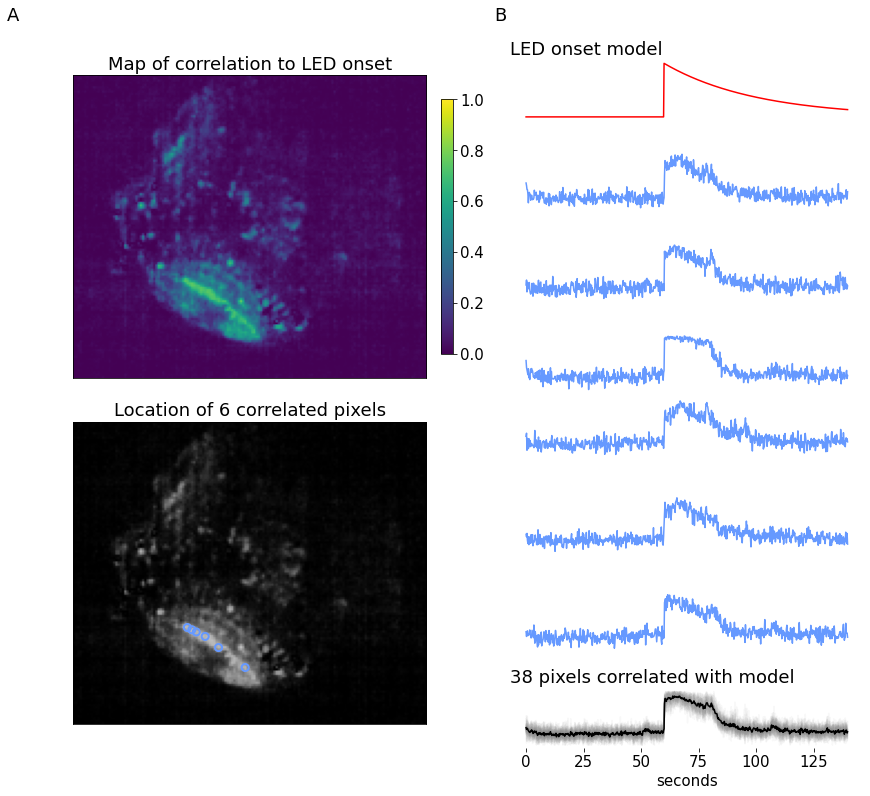

In [19]:
fig = plt.figure(constrained_layout=True, figsize=(12,11))
fig.patch.set_facecolor('white')

nrow = 8 
ncol = 2

gs = fig.add_gridspec(nrow, ncol, width_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0:4, 0])
ax1.set_title('Map of correlation to LED onset')
ax1.axes.yaxis.set_visible(False)
ax1.axes.xaxis.set_visible(False)

# add "subfigure" label
ax1.text(-30, -25, 'A', size=18)
plt1 = ax1.imshow(correlation_map, cmap='viridis', vmin=0.0, vmax=1.0) #displaying the correlation map
fig.colorbar(plt1, ax=ax1,fraction=0.036, pad=0.04)



ax2 = fig.add_subplot(gs[4:8, 0])
ax2title = 'Location of {0} correlated pixels'.format(len(example_correlated_pixels))
ax2.set_title(ax2title)
ax2.axes.yaxis.set_visible(False)
ax2.axes.xaxis.set_visible(False)
plt2 = ax2.imshow(correlation_map, cmap='gray', vmin=0.0, vmax=1.0)
#fig.colorbar(plt2, ax=ax2)


for pixel_ind in example_correlated_pixels: #displaying the spatial location of example correlated pixels
    ax2.scatter(correlation_onset_df.iloc[pixel_ind]['coords'][0], 
                correlation_onset_df.iloc[pixel_ind]['coords'][1], 
                s=50, facecolor='none', edgecolor='#6699ff', linewidths=2)

ax3 = fig.add_subplot(gs[0, 1])
ax3.plot(modelOnset(), color='red', label='onset model') #plotting the LED onset model 
ax3.set_title('LED onset model', loc='left')
ax3.axis('off')
ax3.text(-70, 0.4, 'B', size=18)

# for each ROI out of 6 we will plot line profile:
for roi in range(0,6):
    ax_roi = fig.add_subplot(gs[1+roi, 1])
    x_roi = correlation_onset_df.iloc[example_correlated_pixels[roi]]['coords'][0]
    y_roi = correlation_onset_df.iloc[example_correlated_pixels[roi]]['coords'][1]
    pixel_activity = np.array(LED_video[:, y_roi, x_roi]) #collecting activity from the pixel in LED video
    ax_roi.plot(pixel_activity, color='#6699ff')
    ax_roi.axis('off')


# overlay all traces with correlation > 0.7 to show spread:
ax_overlay = fig.add_subplot(gs[7,1])
for i in range(len(correlation_onset_df)):
    ax_overlay.plot(xaxis, correlation_onset_df.iloc[i][:700], color='gray', alpha=.05)

# calculate average activity of pixels correlated with model
average_activity = np.array(correlation_onset_df.drop('coords', axis=1).mean(axis=0))
ax_overlay.plot(xaxis, average_activity, color='black')
ax_overlay.spines['top'].set_visible(False)
ax_overlay.spines['right'].set_visible(False)
ax_overlay.spines['bottom'].set_visible(False)
ax_overlay.spines['left'].set_visible(False)
ax_overlay.axes.yaxis.set_visible(False)
ax_overlay_title = '{0} pixels correlated with model'.format(len(correlation_onset_df))
ax_overlay.set_title(ax_overlay_title, loc='left')
ax_overlay.set_xlabel('seconds')

plt.savefig(saveFolder + '/LED_correlation.png')

In [16]:
# display all libraries we are using:

import types
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__
list(imports())

['builtins',
 'builtins',
 'matplotlib.pyplot',
 'numpy',
 'pandas',
 'copy',
 'matplotlib',
 'skimage.io',
 'matplotlib.ticker',
 'os',
 'random',
 'time',
 'matplotlib.gridspec',
 'types']